# Instrument recognition in musical audio signals

Group 2: Jakob Dittrich, Lea Franz, David Reiter, Thomas Sickinger


**Description**  
This project focuses on instrumental recognition in musical audio signals. The basic plan is to create a machine learning algorithm that identifies a certain group of instruments.
This will be implemented using the trainings data of the [IRMAS Dataset](https://www.upf.edu/web/mtg/irmas) to learn and test the model.

**Outcome measurements**  
Precision and Recall are the most important evaluation characteristics but the possible outcomes can also be measured with an accuracy score in percent.


## Setup


In [1]:
import csv
import pathlib
from PIL import Image
import os
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from os import listdir
import librosa.display
import pickle
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score, \
    balanced_accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm

%matplotlib inline

# color for plots
pltcolor = '#002b36'
plt.rcParams['figure.figsize'] = [16, 9]

In [2]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

## Data


The training data contains 6705 audio files in 16 bit stereo wav format sampled at 44.1kHz. They are excerpts of 3 seconds from more than 2000 distinct recordings. The number of files per instrument are: cello (388), clarinet (505), flute (451), acoustic guitar (637), electric guitar (760), organ (682), piano (721), saxophone (626), trumpet (577), violin (580), human voice (778).

The test data contains 2874 excerpts in 16 bit stereo wav format sampled at 44.1kHz.

The music is from different decades, recording and production style and musical genres. There is one predominant target instrument per excerpt.

Source: https://www.upf.edu/web/mtg/irmas


### Loading the data

For loading the audio data we use **librosa**. This is python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems. In this project it is used for loading .wav files, extracting features and visualizations.


## Analysis of data


### Instrument class balance


In [3]:
class_dirs = os.listdir('./IRMAS-TrainingData/')
#class_dirs.remove('.DS_Store')
#class_dirs.remove('README.txt')
class_dirs

['cel',
 'cla',
 'flu',
 'gac',
 'gel',
 'org',
 'pia',
 'README.txt',
 'sax',
 'tru',
 'vio',
 'voi']

This project uses the following instruments:


In [4]:
Instruments = sorted(['vio', 'pia', 'org', 'gel', 'gac', 'voi'])
Instruments

['gac', 'gel', 'org', 'pia', 'vio', 'voi']

The plot shows that the the numbers of samples per instrument are not balanced. The instrument with the most samples is **voi** and the instrument with the least samples is **vio**.


[Text(0, 0, '637'),
 Text(0, 0, '760'),
 Text(0, 0, '682'),
 Text(0, 0, '721'),
 Text(0, 0, '580'),
 Text(0, 0, '778')]

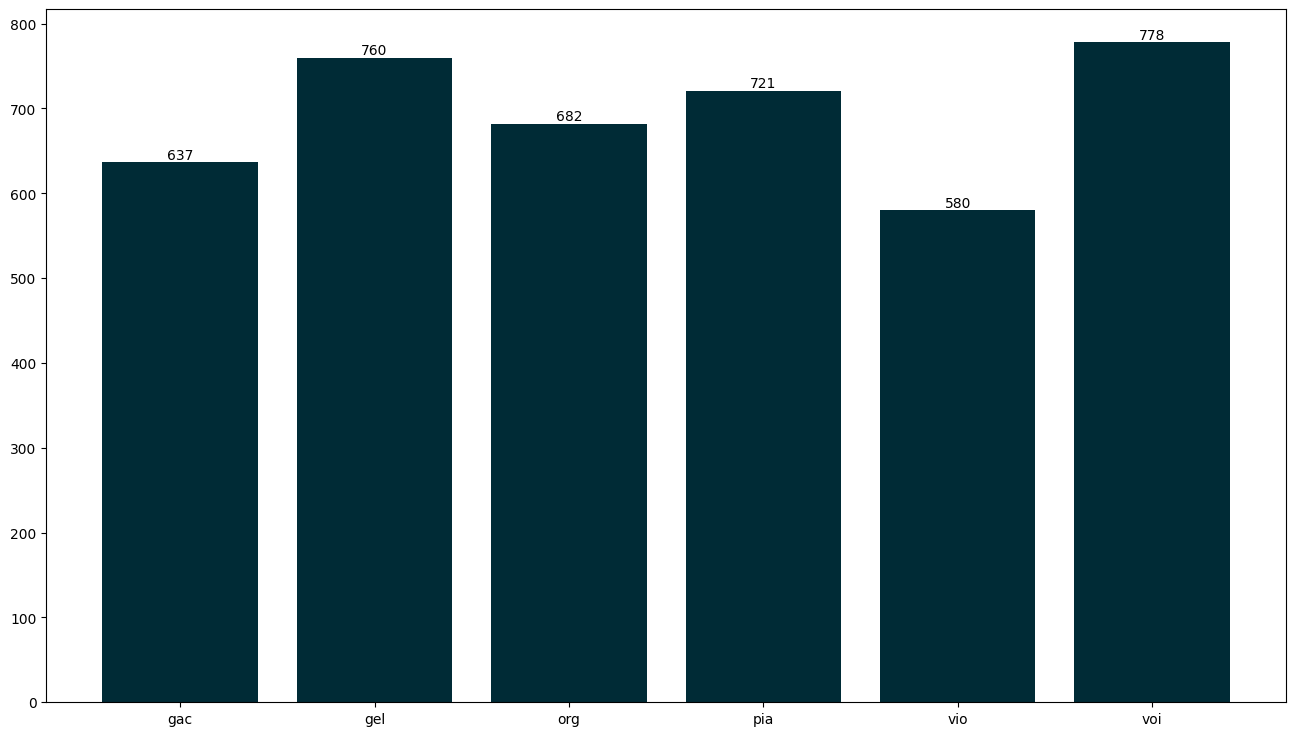

In [5]:
number_of_files = []
for class_name in Instruments:
    class_dir = os.listdir('./IRMAS-TrainingData/'+class_name)
    number_of_files.append(len(class_dir))

fig, ax = plt.subplots()
bars = ax.bar(Instruments, number_of_files, color=pltcolor)
ax.bar_label(bars)

### Example file


These visualizations of an excerpt including a cello and clarinet without drums show the waveform in the time domain as well as the spectrogram.


In [6]:
y, sr = librosa.load(
    './IRMAS-TrainingData/cel/008__[cel][nod][cla]0058__1.wav')

**Waveform in the time domain**


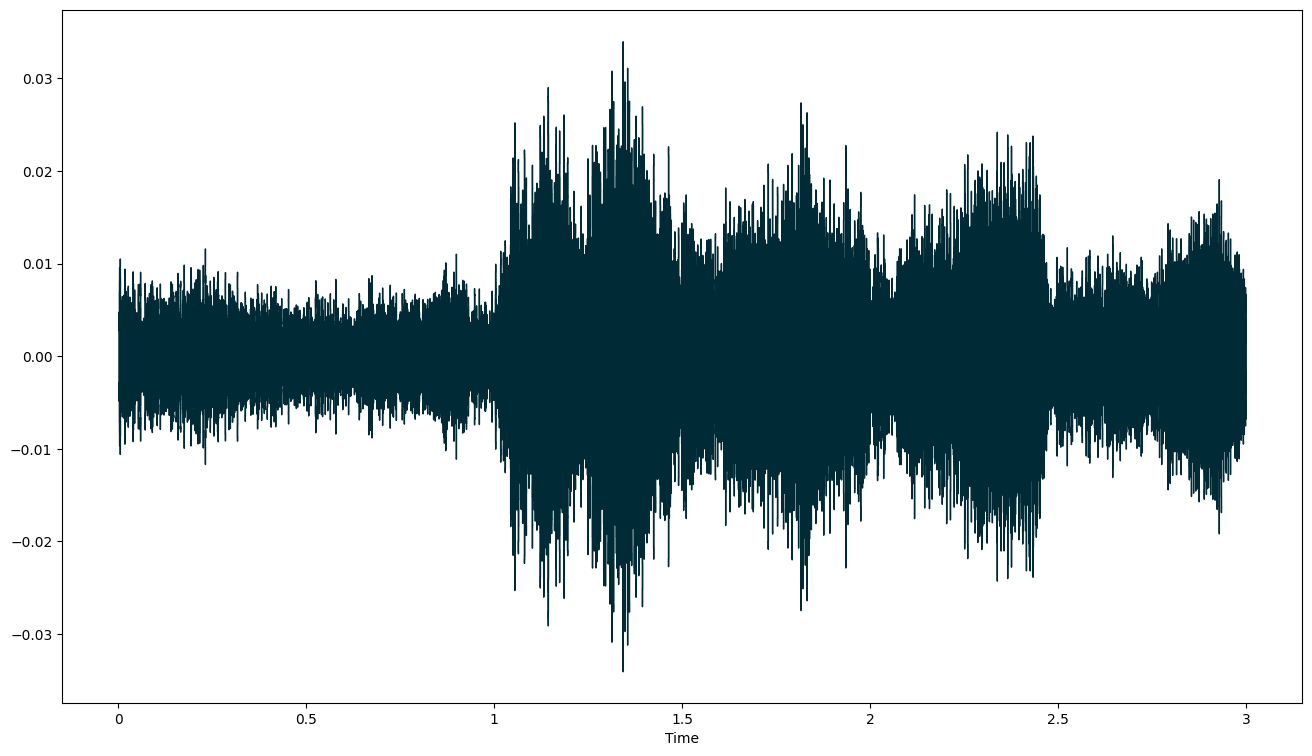

In [7]:
librosa.display.waveshow(y, sr=sr, color=pltcolor)

**Spectrogram**

A spectrogram is the visual representation of the spectrum of frequencies of a signal over time.


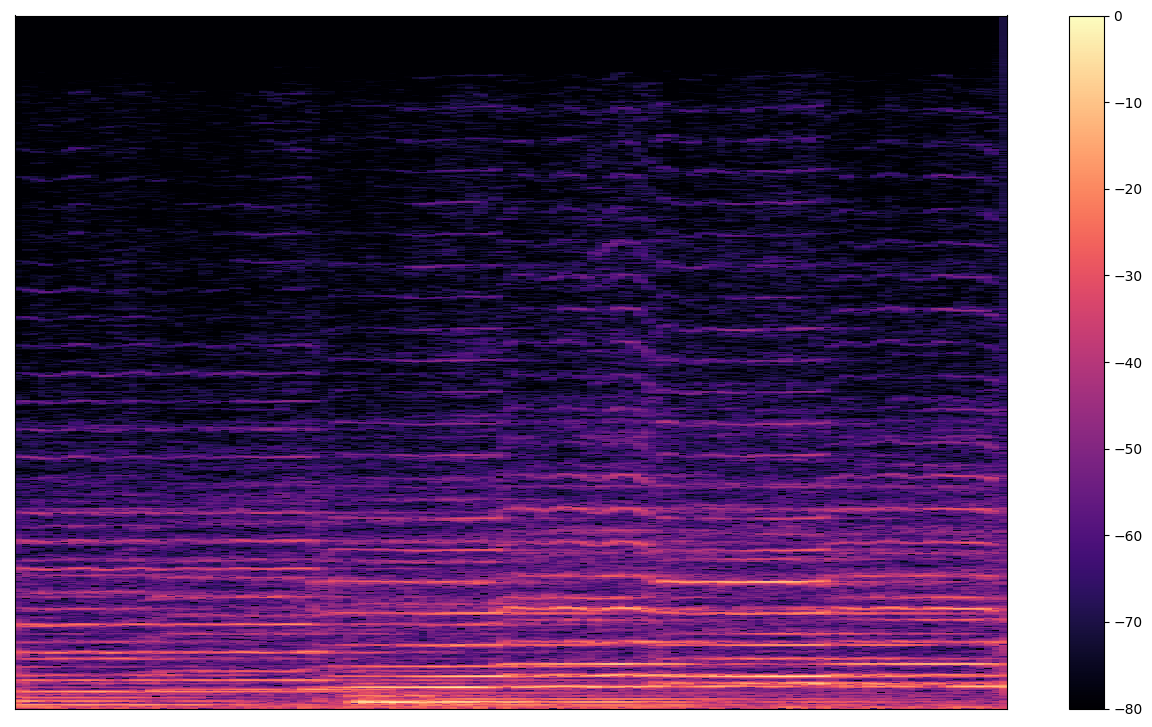

In [8]:
stft = librosa.stft(y)  # short time fourier transform
magnitudes_to_decibel = librosa.amplitude_to_db(
    np.abs(stft), ref=np.max)  # mapping magnitudes to decibel scale

plt.figure()
librosa.display.specshow(magnitudes_to_decibel)
plt.colorbar()

## Feature extraction


The following features were selected for extraction based on research on audio processing as well as the librosa API:


**Zero Crossing Rate:** the rate at which the signal crosses zero

**Spectral Centroid:** the center of mass in the spectrum

**Spectral Bandwidth:** the weighted average of the frequency signal by its spectrum

**Spectral Roll-Off:** frequency below a specified percentage of the total spectral energy

**Root mean square value:** the mean value of the signals curve

**Mel-frequency cepstral coefficients:** represent the unique characteristics of a sound

**Melspectrogram:** the spectrogram where the frequencies are converted to the mel scale


We use 20 mfccs to represent the audio file because it is the most common number of mfccs used in audio classification.

In [9]:
header = '''filename 
            rms 
            spectral_centroid 
            spectral_bandwidth 
            rolloff 
            zero_crossing_rate 
            melspectrogram'''
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

Creating a .csv file for storing the data from the music files as extracted features


In [10]:
csv_exists = True

if csv_exists == False:
    file = open('data.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)

In [11]:
if csv_exists == False:
    file = open('data.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)

    for i in Instruments:
        for filename in os.listdir(f'./IRMAS-TrainingData/{i}'):
            songname = f'./IRMAS-TrainingData/{i}/{filename}'
            y, sr = librosa.load(songname, sr=44100)
            rms = librosa.feature.rms(y=y)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            melspec = librosa.feature.melspectrogram(y=y, sr=sr)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            to_append = f"""{filename} 
                    {np.mean(rms)} 
                    {np.mean(spec_cent)} 
                    {np.mean(spec_bw)} 
                    {np.mean(rolloff)} 
                    {np.mean(zcr)} 
                    {np.mean(melspec)}"""
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            to_append += f' {i}'
            file = open('data.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

In [12]:
df = pd.read_csv('data.csv')
df.head()

,filename,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,melspectrogram,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,[gac][pop_roc]0599__1.wav,0.149846,1765.455284,2316.768276,3881.463788,0.039434,4.478055,-177.740768,183.106140,-39.298458,...,-11.224849,-0.596448,-2.143378,0.162669,0.592024,1.232375,-4.601346,-0.404293,0.554153,gac
1,[gac][pop_roc]0684__3.wav,0.057256,2151.740046,2871.003264,4424.615973,0.041368,0.638174,-244.451920,168.364059,-34.875370,...,-1.734322,-7.018749,-3.163468,-9.860246,-5.122176,-5.768988,-7.969817,3.261638,-2.437297,gac
2,[gac][pop_roc]0730__1.wav,0.115933,1873.659860,2481.265138,4122.319732,0.035081,2.594097,-197.755005,174.568192,-47.049984,...,5.519228,0.744397,-1.831121,0.658741,-2.435940,-1.233488,2.814769,6.446696,-0.061629,gac
3,202__[gac][dru][cou_fol]0673__1.wav,0.150271,4605.320058,4464.928423,10142.637511,0.132926,4.046965,-88.515511,115.689247,-20.837677,...,10.548104,-4.208836,10.606059,-4.000640,0.370844,4.349768,-0.125940,-0.440510,-5.983281,gac
4,[gac][pop_roc]0630__1.wav,0.046989,1068.316666,1511.278029,1623.719911,0.027089,0.552503,-362.860657,197.322754,-0.209483,...,-11.928788,-15.832193,-12.129809,-2.833784,3.045583,0.593217,-0.298925,2.188061,-0.352950,gac


## Analysis of features


[Text(0, 0, '778'),
 Text(0, 0, '760'),
 Text(0, 0, '721'),
 Text(0, 0, '682'),
 Text(0, 0, '637'),
 Text(0, 0, '580')]

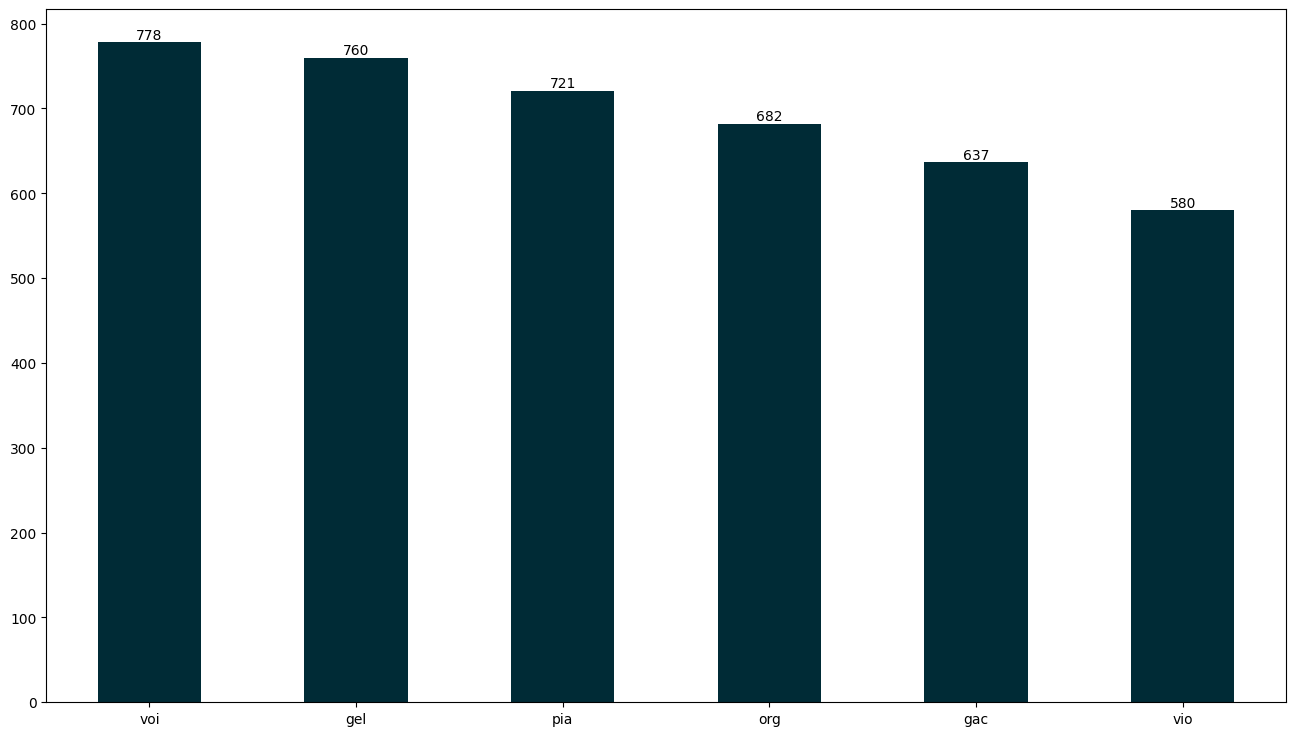

In [13]:
table = df['label'].value_counts()
ax = table.plot(kind='bar', rot=0, color=pltcolor)
ax.bar_label(ax.containers[0])

The class imbalance and the number of samples per instrument are still the same after the feature extraction.


### Correlation between features


The most correlated features are spectral_centroid and rolloff, rms and melspectrogram as well as spectral bandwith and rolloff.


In [14]:
df_corr = df
df_corr.corr().unstack().sort_values().drop_duplicates()

spectral_centroid   mfcc2                -0.832009
mfcc2               spectral_bandwidth   -0.820206
                    rolloff              -0.774466
mfcc4               mfcc2                -0.645317
mfcc6               mfcc2                -0.598631
                                            ...   
spectral_centroid   spectral_bandwidth    0.900877
spectral_bandwidth  rolloff               0.932395
rms                 melspectrogram        0.950055
spectral_centroid   rolloff               0.965179
rms                 rms                   1.000000
Length: 326, dtype: float64

**Highest correlation between spectral_centroid and rolloff**


<AxesSubplot: xlabel='spectral_centroid', ylabel='rolloff'>

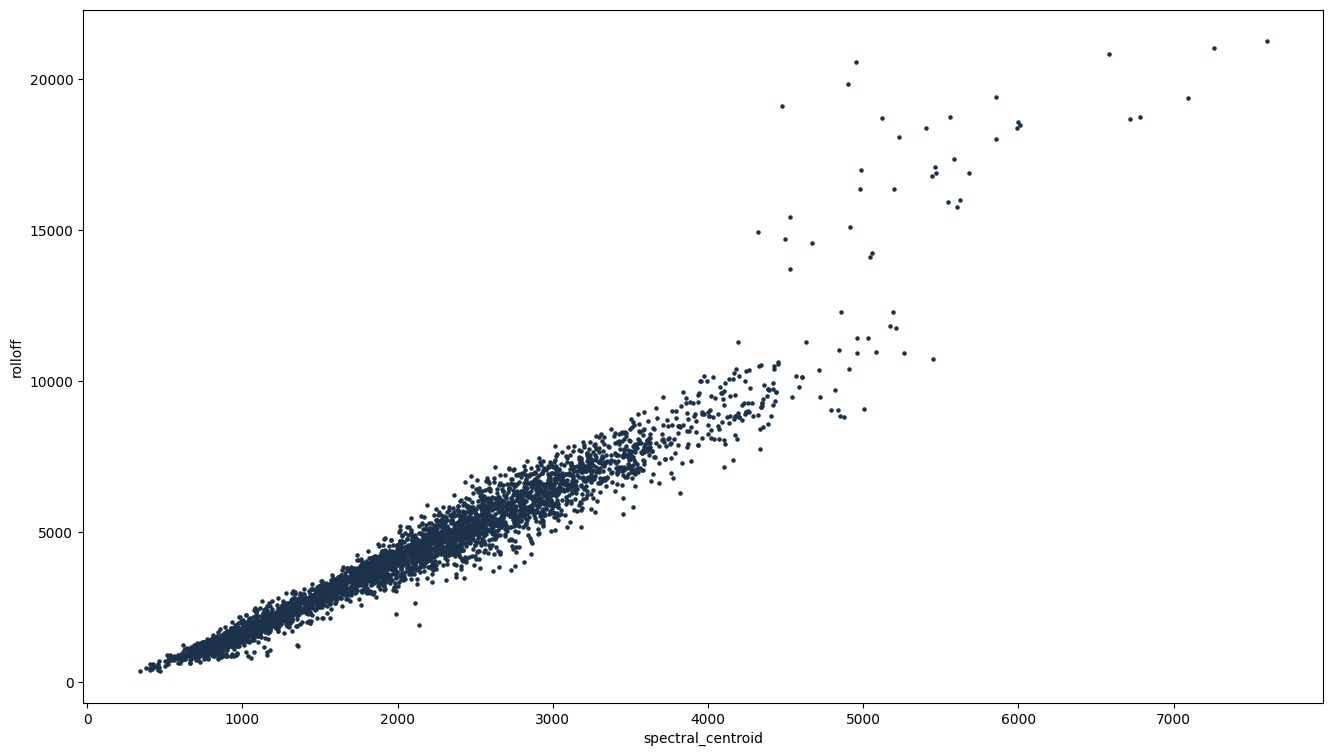

In [15]:
df.plot.scatter("spectral_centroid", "rolloff", c="#1b324a", marker='.')

## Preprocessing


### NaN values


In [16]:
df.isnull().values.any()

False

There are no NaN values in this dataset.


### Outliers


The outliers were set to the lower or upper limit instead of removing them to keep more information and improve the model performance.


In [17]:
cols = df.columns.tolist()
cols.remove('label')
cols.remove('filename')

for col in cols:
    q25 = df[col].quantile(0.25)
    q75 = df[col].quantile(0.75)
    intr_qr = q75-q25

    q_hi = q75+(1.5*intr_qr)
    q_low = q25-(1.5*intr_qr)

    df.loc[df[col] < q_low, col] = q_low
    df.loc[df[col] > q_hi, col] = q_hi
    df_filtered = df[(df[col] < q_hi) & (df[col] > q_low)]

print(str(len(df)-len(df_filtered)) +
      ' rows with outliers detected. Outliers were set to the lower or upper limit.')

90 rows with outliers detected. Outliers were set to the lower or upper limit.


### Scaling


The data gets scaled with the StandardScaler to change the distribution by which removing the mean and scaling each feature to unit variance.

Before that, the labels get transformed from strings like voi to numeric values.


In [18]:
# drop filename from dataframe
df = df.drop(['filename'], axis=1)

In [19]:
# extract instrument labels
instru_list = df.iloc[:, -1]
encoder = LabelEncoder()

# encode labels to numeric values
y = encoder.fit_transform(instru_list)
labels = y

df['label'] = y

# uniformly scale data
scaler = StandardScaler()
X_transform = scaler.fit_transform(df.iloc[:, :-1].values)

# save scaler
pickle.dump(scaler, open('./scaler.pkl', 'wb'))

<AxesSubplot: title={'center': 'Data after scaling'}, ylabel='Density'>

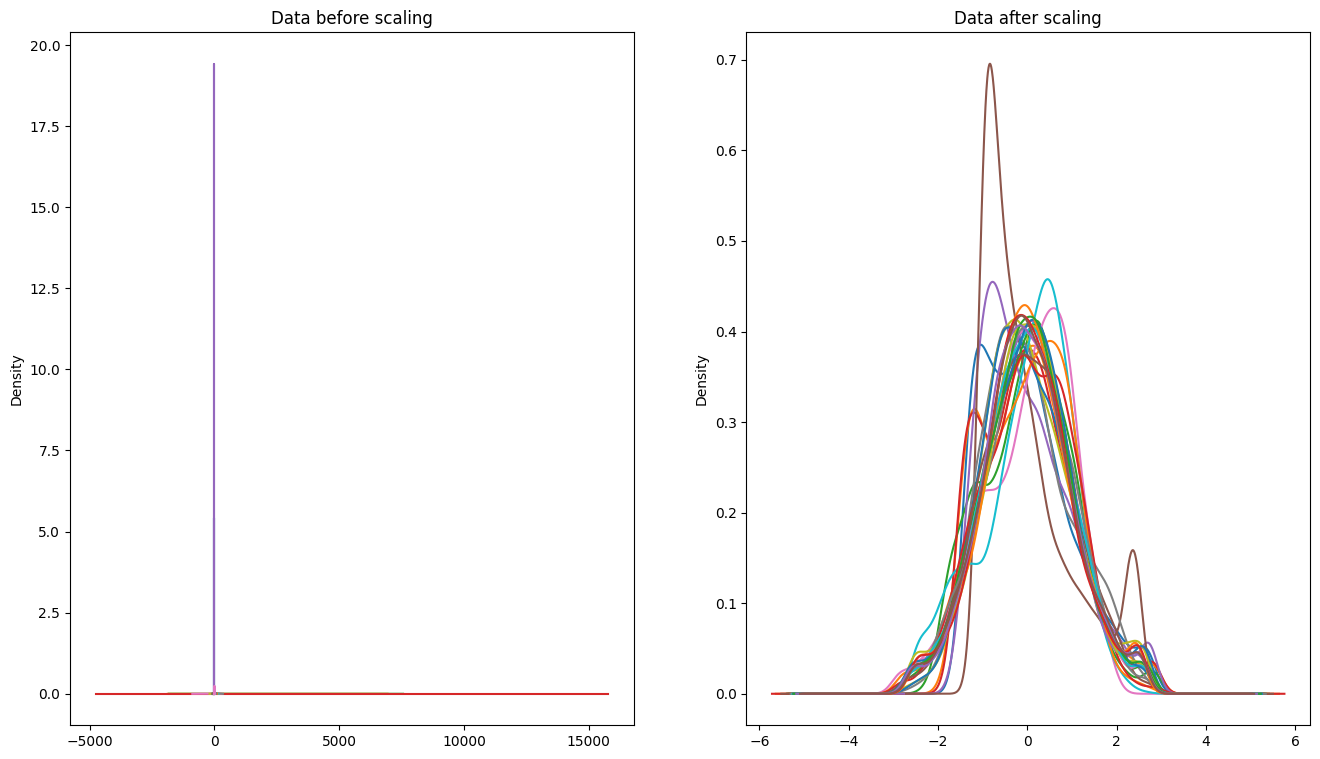

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title("Data before scaling")
ax2.set_title("Data after scaling")

df.plot.density(ax=ax1, legend=False)
df_scaled = pd.DataFrame(X_transform, columns=df.iloc[:, :-1].columns)
df_scaled.plot.density(ax=ax2, legend=False)

In [21]:
# print labels
print('Numberic values instead of class names: ')
print(y)

Numberic values instead of class names: 
[0 0 0 ... 5 5 5]


### Features


The main feature extraction was already done by extracting the features from the .wav files.


#### Feature reduction with PCA


This plot shows the explained variance ratio when 95% of variance is kept. 95% was chosen because otherwise the model performance would decrease too much.  
Feature reduction with PCA wil be applied later when training the models using a pipeline.


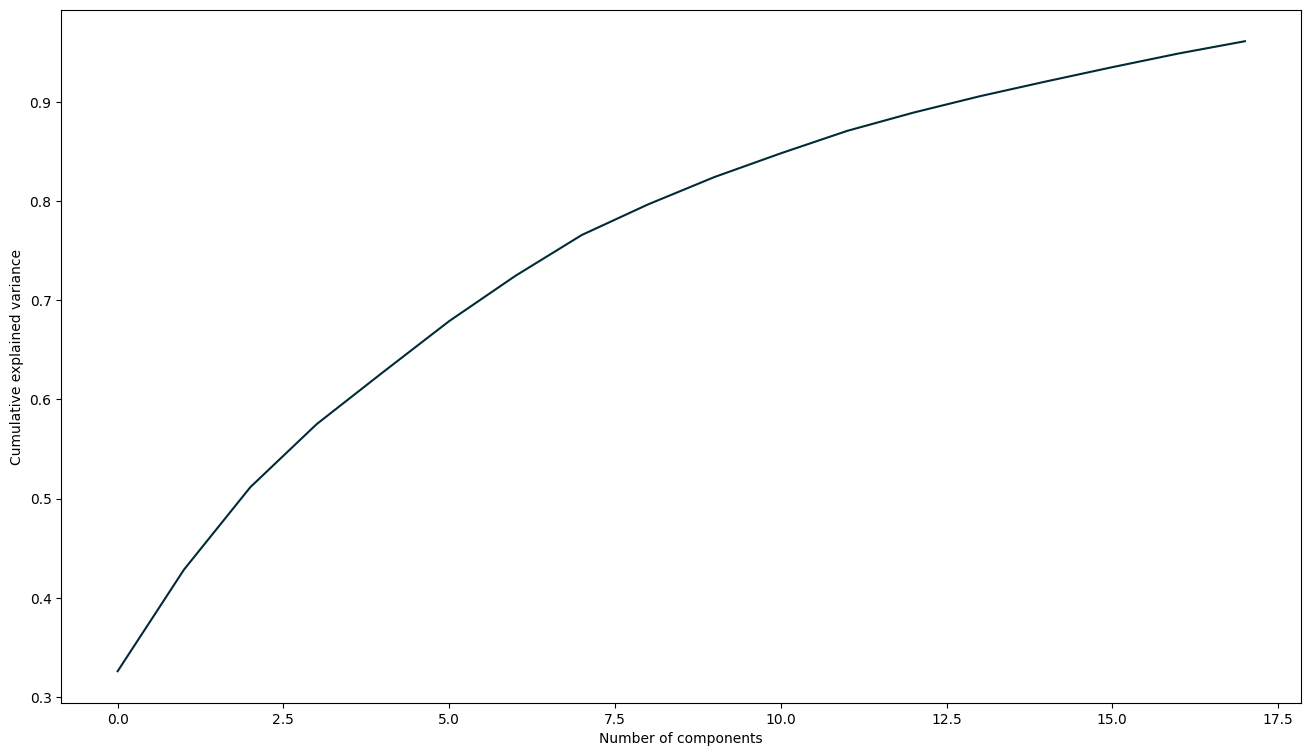

In [22]:
pca = PCA(n_components=0.95)
X_pca = pca.fit(X_transform)
plt.plot(np.cumsum(pca.explained_variance_ratio_), color=pltcolor)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

PCA with 95% variance means 18 components in this case.


In [23]:
X_pca = pca.transform(X_transform)
X_pca.shape

(4158, 18)

Text(0.5, 1.0, 'Transformed data by principal components (95%)')

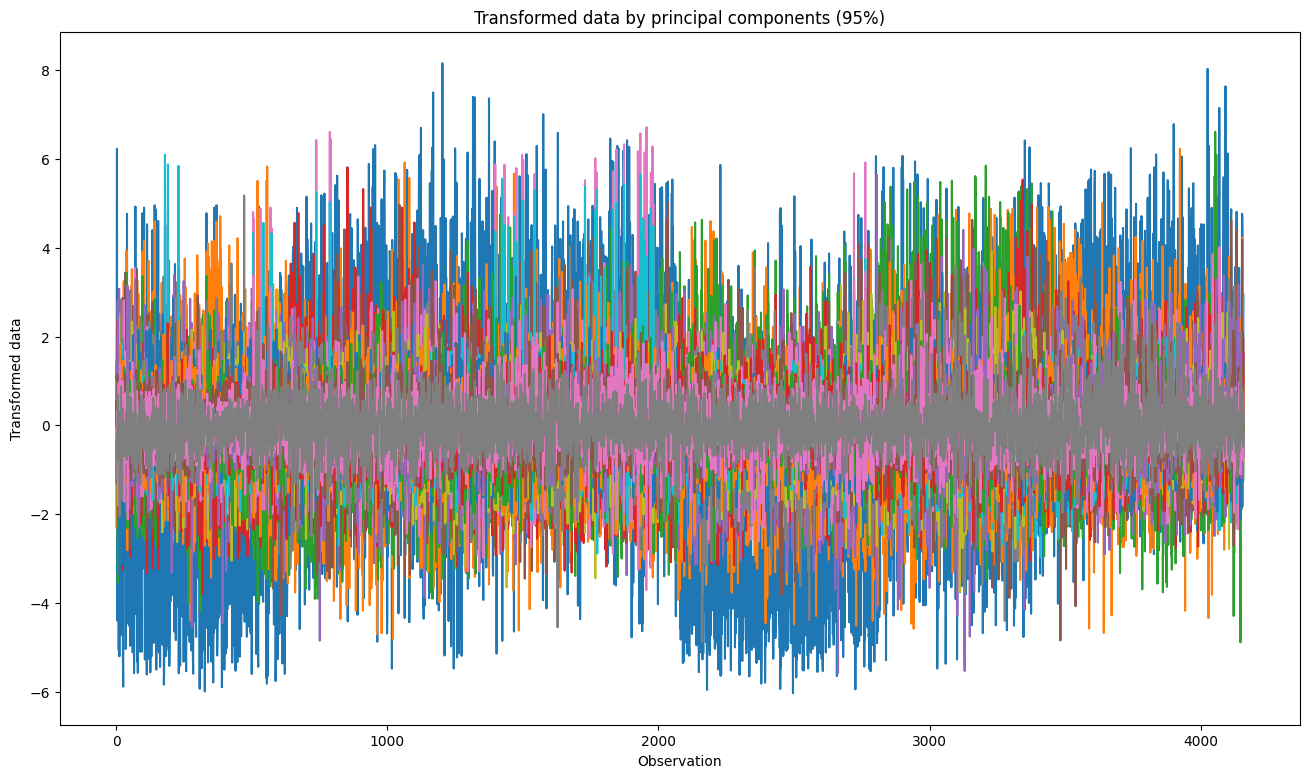

In [24]:
plt.plot(X_pca)
plt.xlabel('Observation')
plt.ylabel('Transformed data')
plt.title('Transformed data by principal components (95%)')

## Models


At this point, the data is sorted by the class labels. Therefore the data has to be shuffled to prevent having all samples from an instrument only in the trainings data and not in the test data.


In [25]:
# shuffle dataframe
df1 = shuffle(df)
df1.head()

,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,melspectrogram,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
3177,0.052269,1449.935244,1786.945693,2621.314136,0.038816,0.558907,-302.774445,202.877899,-43.661594,22.781029,...,-9.495952,-7.584971,-7.495331,-6.035081,-3.163514,4.299675,6.699451,2.755439,-1.330529,4
3755,0.107469,1316.476016,2059.157427,2116.073691,0.029942,2.764056,-296.558472,176.003738,13.155663,22.491045,...,4.910737,-12.035106,-5.116690,-7.137943,-9.854990,-3.389129,-8.926827,-12.766237,-9.591013,5
148,0.054171,714.841763,1064.251549,1084.558435,0.019205,0.672873,-376.727997,227.577774,32.180553,-2.936153,...,-8.233808,-6.483662,-12.999207,-16.782177,-13.491032,-10.034054,-7.966405,-1.641275,3.888662,0
204,0.056894,1387.389959,2410.679651,2366.906408,0.028673,0.698325,-293.194244,181.370285,-1.779350,33.544144,...,3.919997,-4.086143,-5.397425,-16.225597,-2.714331,-8.434624,-2.146961,-3.268332,-5.959395,0
653,0.063364,1955.594359,3121.499202,4710.284259,0.025879,0.875096,-285.622253,157.327637,8.098010,60.486813,...,-1.973058,4.718350,-5.827966,-0.502945,-4.395912,-3.894753,1.428026,-2.986673,-3.159881,1


To predict how well the model can handle new data which it has not seen before, the data is split into a train/test split. The test data is only used for the best estimator for each model type.


In [26]:
# split dataset in train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X_transform, y, test_size=0.2)

In [27]:
def print_model_result(predicted_labels):
    print("Recall: ", recall_score(y_test, predicted_labels, average=None))
    print("Recall Average: ", recall_score(
        y_test, predicted_labels, average="micro"))
    print("Precision: ", precision_score(
        y_test, predicted_labels, average=None))
    print("Precision Average: ", precision_score(
        y_test, predicted_labels, average="micro"))
    print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
    print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,
          normalize=True), accuracy_score(y_test, predicted_labels, normalize=False))
    print("Balanced accuracy: %.2f  ," % balanced_accuracy_score(
        y_test, predicted_labels), balanced_accuracy_score(y_test, predicted_labels))

    print("Number of samples:", y_test.shape[0])
    ConfusionMatrixDisplay(confusion_matrix(
        y_test, predicted_labels), display_labels=Instruments).plot(cmap="Blues")

The following models were trained and evaluated with hyperparameter search and 10 fold cross validation:

- SVM
- Neural Network
- KNN
- Logistic Regression
- Random Forest


### SVM Model


In [28]:
from sklearn.utils.fixes import loguniform
tuning_params_svm = {"C": [3**n for n in range(-5, 5)], "gamma": [
    3**n for n in range(-5, 5)], "kernel": ['rbf', 'sigmoid']}
param_grid_svm = {}

for key, value in tuning_params_svm.items():
    hyperparam_key = "classify__" + key
    param_grid_svm[hyperparam_key] = value

In [31]:
pipe = Pipeline([
    ('classify', SVC())
])

gs = GridSearchCV(pipe, param_grid=param_grid_svm,
                  cv=10, scoring="balanced_accuracy", n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('classify', SVC())]), n_jobs=-1,
             param_grid={'classify__C': [0.00411522633744856,
                                         0.012345679012345678,
                                         0.037037037037037035,
                                         0.1111111111111111, 0.3333333333333333,
                                         1, 3, 9, 27, 81],
                         'classify__gamma': [0.00411522633744856,
                                             0.012345679012345678,
                                             0.037037037037037035,
                                             0.1111111111111111,
                                             0.3333333333333333, 1, 3, 9, 27,
                                             81],
                         'classify__kernel': ['rbf', 'sigmoid']},
             scoring='balanced_accuracy')

In [32]:
print('Best parameters: '+str(gs.best_params_))
print('Best balanced accuracy score: '+str(gs.best_score_))

Best parameters: {'classify__C': 27, 'classify__gamma': 0.1111111111111111, 'classify__kernel': 'rbf'}
Best balanced accuracy score: 0.7751992643564594


Recall:  [0.89189189 0.79865772 0.76811594 0.70779221 0.74590164 0.74683544]
Recall Average:  0.7716346153846154
Precision:  [0.7173913  0.73913043 0.8030303  0.81954887 0.76470588 0.79194631]
Precision Average:  0.7716346153846154
F1-Score:  [0.79518072 0.76774194 0.78518519 0.75958188 0.75518672 0.76872964]
Accuracy: 0.77  , 642
Balanced accuracy: 0.78  , 0.7765324737026879
Number of samples: 832


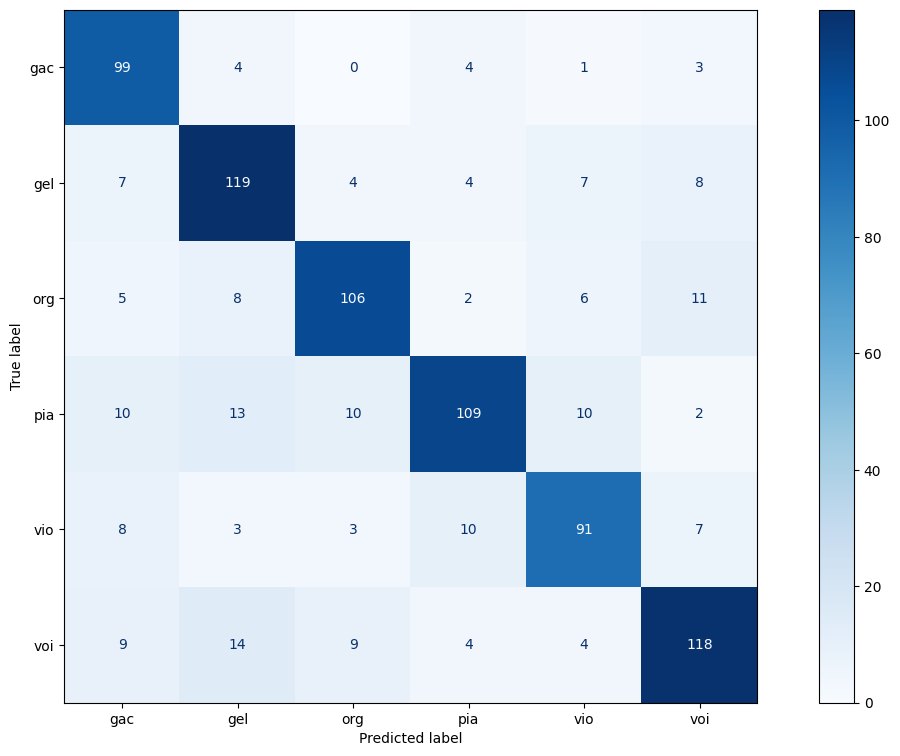

In [33]:
predicted_labels = gs.best_estimator_.predict(X_test)
predicted_labels_svm = predicted_labels
gs_svm = gs

best_svm_model = gs.best_estimator_

# save model
pickle.dump(best_svm_model, open('./model.pkl', 'wb'))

print_model_result(predicted_labels)

### Neural Network


We used all of the commented param grids to find the best parameters for the neural network and used them in the create_model function.

In [34]:
# create a function to build the neural network model
def create_model(neurons):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(26,),
              kernel_initializer='he_uniform', kernel_constraint=MaxNorm(1)))
    model.add(Dropout(0.1))
    model.add(Dense(6, activation='sigmoid', kernel_initializer='he_uniform'))
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(
        learning_rate=0.001), metrics=['accuracy'])
    return model


# create the model with KerasClassifier
model = KerasClassifier(build_fn=create_model,
                        verbose=0, epochs=100, batch_size=10)

# define the grid search parameters
# param_grid = {'epochs': [10, 50, 100], 'batch_size': [10, 20, 40, 60, 80, 100]}
# param_grid = {'optimizer': ['SGD', 'RMSprop', 'Adagrad', 
#       'Adadelta', 'Adam', 'Adamax', 'Nadam']}
# param_grid = {'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]}
# param_grid = {'init_mode': [
#       'uniform', 'lecun_uniform', 'normal', 'zero', 
#       'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'
#   ]}
# param_grid = {
#       'weight_constraint': 
#           [1.0, 2.0, 3.0, 4.0, 5.0], 
#       'dropout_rate': 
#           [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
param_grid_nn = {'neurons': [1, 5, 10, 15, 20, 25, 30, 64, 128, 256]}

# create the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid_nn, cv=3, n_jobs=-1)

# fit the grid search on the data
grid.fit(X_train, y_train)

# print the best parameters and the corresponding score
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.672580 using {'neurons': 256}


26/26 [==============================] - 0s 555us/step
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-01-26 21:16:56         2016
metadata.json                                  2023-01-26 21:16:56           64
variables.h5                                   2023-01-26 21:16:56       121656
Recall:  [0.79279279 0.66442953 0.74637681 0.7012987  0.68032787 0.68987342]
Recall Average:  0.7091346153846154
Precision:  [0.61538462 0.7443609  0.70547945

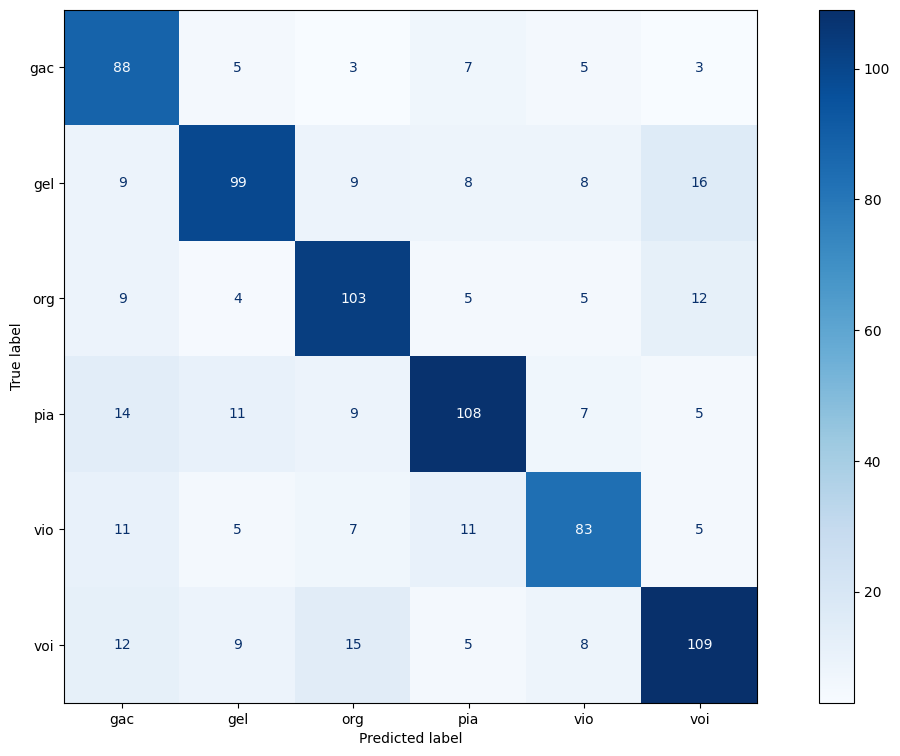

In [35]:
predicted_labels = grid.best_estimator_.predict(X_test)
predicted_labels_nn = predicted_labels
gs_nn = grid

best_nn_model = grid.best_estimator_

# save model
pickle.dump(best_nn_model, open('./nn.pkl', 'wb'))

print_model_result(predicted_labels)

### KNN


In [75]:
knn_hyperparameters = list(range(1, 31))

In [76]:
knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=knn_hyperparameters)

# defining parameter range
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10,
                    scoring='balanced_accuracy', 
                    return_train_score=False, verbose=1, n_jobs=-1)

# fitting the model for grid search
grid_search = grid.fit(X_train, y_train)

accuracy = grid_search.best_score_ * 100
print("Best params: "+str(grid_search.best_params_))
print("Balanced accuracy for our training dataset with tuning is : {:.2f}%"\
    .format(accuracy))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best params: {'n_neighbors': 1}
Balanced accuracy for our training dataset with tuning is : 75.82%


Recall:  [0.82882883 0.79194631 0.7826087  0.77272727 0.71311475 0.78481013]
Recall Average:  0.7788461538461539
Precision:  [0.76666667 0.71084337 0.8        0.82068966 0.79090909 0.79487179]
Precision Average:  0.7788461538461539
F1-Score:  [0.7965368  0.74920635 0.79120879 0.79598662 0.75       0.78980892]
Accuracy: 0.78  , 648
Balanced accuracy: 0.78  , 0.7790059977689577
Number of samples: 832


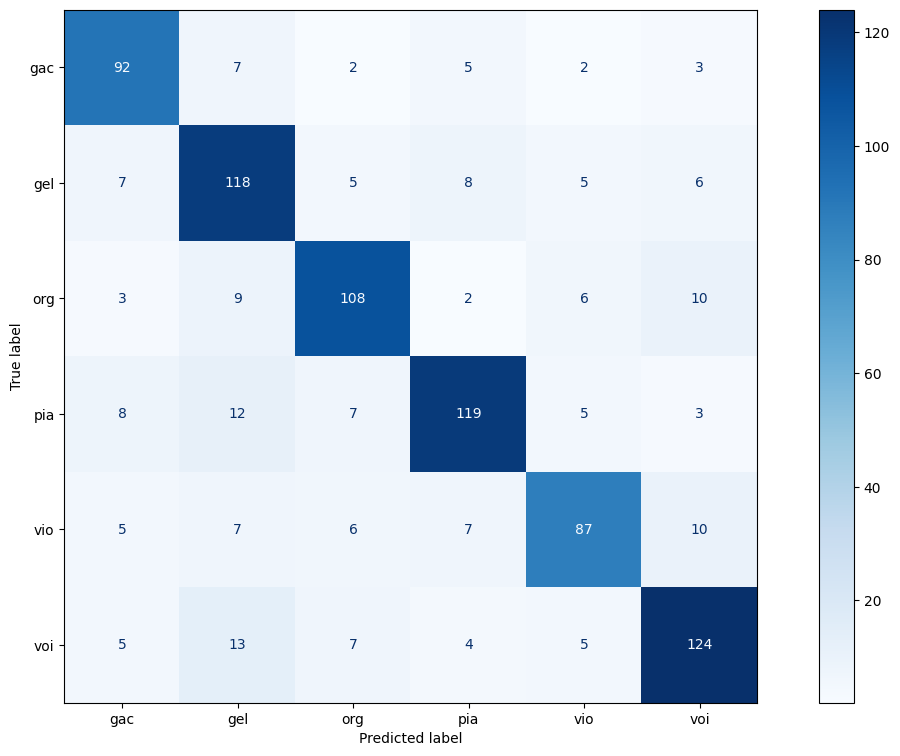

In [38]:
predicted_labels = grid_search.best_estimator_.predict(X_test)
predicted_labels_knn = predicted_labels

best_knn_model = grid_search.best_estimator_
gs_knn = grid_search

# save model
pickle.dump(best_knn_model, open('./knn.pkl', 'wb'))

print_model_result(predicted_labels)

### Logistic Regression


In [39]:
tuning_params_logr = {"C": np.logspace(-4, 4, 20), 
    "penalty": ["l1", "l2", "none", "elasticnet"], 
    'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']}  # l1 lasso l2 ridge
param_grid_logr = {}

for key, value in tuning_params_logr.items():
    hyperparam_key = "classify__" + key
    param_grid_logr[hyperparam_key] = value

In [40]:
pipe = Pipeline([
    ('classify', LogisticRegression())
])

gs = GridSearchCV(pipe, param_grid=param_grid_logr,
                  cv=10, scoring="balanced_accuracy", n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classify', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classify__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'classify__penalty': ['l1', 'l2', 'none',
                                               'elasticnet'],
                         'classify__solver': ['lbfgs', 'newton-cg', 'liblinear',
                                              'sag', 'saga']},
             scoring='balanced_accuracy')

In [41]:
print('Best parameters: '+str(gs.best_params_))
print('Best balanced accuracy score: '+str(gs.best_score_))

Best parameters: {'classify__C': 11.288378916846883, 'classify__penalty': 'l2', 'classify__solver': 'sag'}
Best balanced accuracy score: 0.5514939437018225


Recall:  [0.62162162 0.48993289 0.56521739 0.7012987  0.52459016 0.51265823]
Recall Average:  0.5685096153846154
Precision:  [0.53488372 0.48344371 0.52702703 0.675      0.77108434 0.50310559]
Precision Average:  0.5685096153846154
F1-Score:  [0.575      0.48666667 0.54545455 0.68789809 0.62439024 0.50783699]
Accuracy: 0.57  , 473
Balanced accuracy: 0.57  , 0.5692198319855398
Number of samples: 832


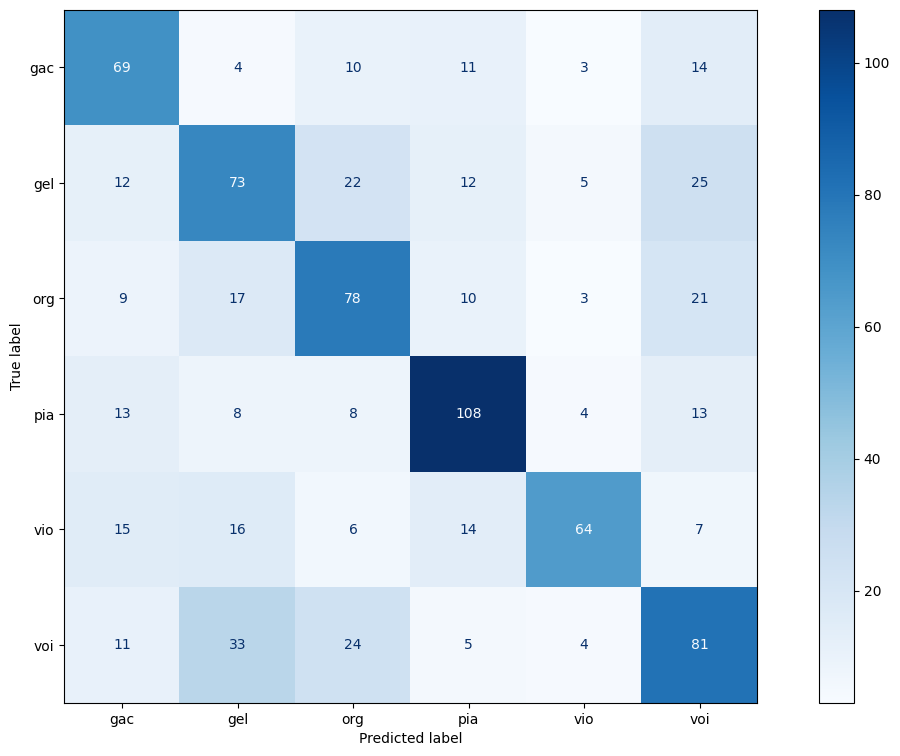

In [42]:
predicted_labels = gs.best_estimator_.predict(X_test)
best_logreg_model = grid_search.best_estimator_
predicted_labels_logreg = predicted_labels
gs_logreg = gs

pickle.dump(best_logreg_model, open('./log_reg.pkl', 'wb'))

print_model_result(predicted_labels)

### Random Forest


In [43]:
tuning_params_rf = {
    'max_depth': [30, 40, 50, 60],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200]}


param_grid_rf = {}

for key, value in tuning_params_rf.items():
    hyperparam_key = "classify__" + key
    param_grid_rf[hyperparam_key] = value

In [44]:
gs = GridSearchCV(RandomForestClassifier(), param_grid=tuning_params_rf,
                  cv=10, scoring="balanced_accuracy", n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [30, 40, 50, 60],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200]},
             scoring='balanced_accuracy')

In [45]:
print('Best parameters: '+str(gs.best_params_))
print('Best balanced accuracy score: '+str(gs.best_score_))
print('Importances of the features: ', gs.best_estimator_.feature_importances_)

Best parameters: {'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best balanced accuracy score: 0.690840512331752
Importances of the features:  [0.05014678 0.03678692 0.03771281 0.03989598 0.04276287 0.04518187
 0.05637262 0.03155931 0.05585029 0.04983389 0.04338727 0.04616827
 0.04458425 0.03665596 0.02887117 0.03141963 0.03022751 0.03781116
 0.0310608  0.03212305 0.02997482 0.03028691 0.03229292 0.03209391
 0.0284928  0.03844623]


**Importance of the features**


<BarContainer object of 26 artists>

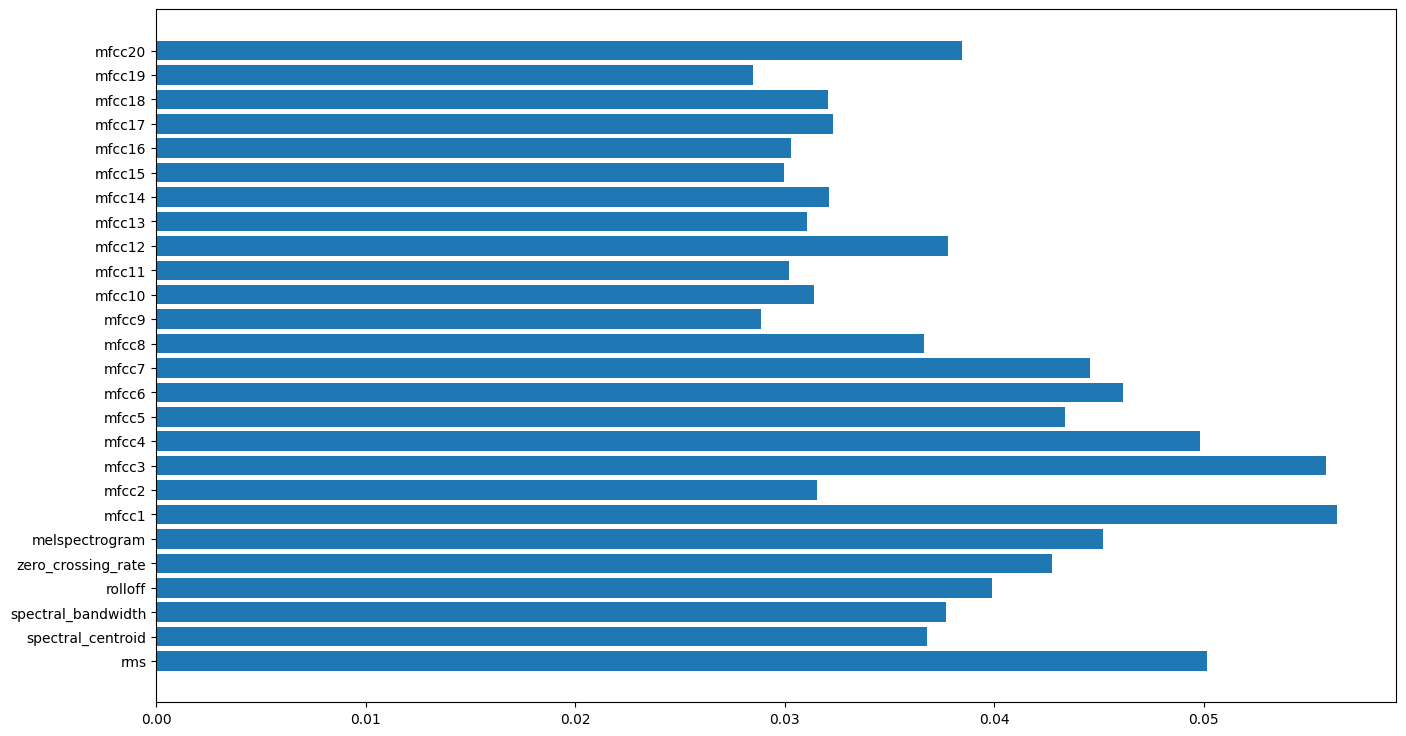

In [46]:
plt.barh(df.iloc[:, :-1].columns, gs.best_estimator_.feature_importances_)

Recall:  [0.79279279 0.67785235 0.68115942 0.70779221 0.67213115 0.76582278]
Recall Average:  0.7151442307692307
Precision:  [0.67175573 0.71126761 0.71755725 0.78985507 0.82828283 0.63350785]
Precision Average:  0.7151442307692307
F1-Score:  [0.72727273 0.69415808 0.69888476 0.74657534 0.74208145 0.69340974]
Accuracy: 0.72  , 595
Balanced accuracy: 0.72  , 0.7162584503698758
Number of samples: 832


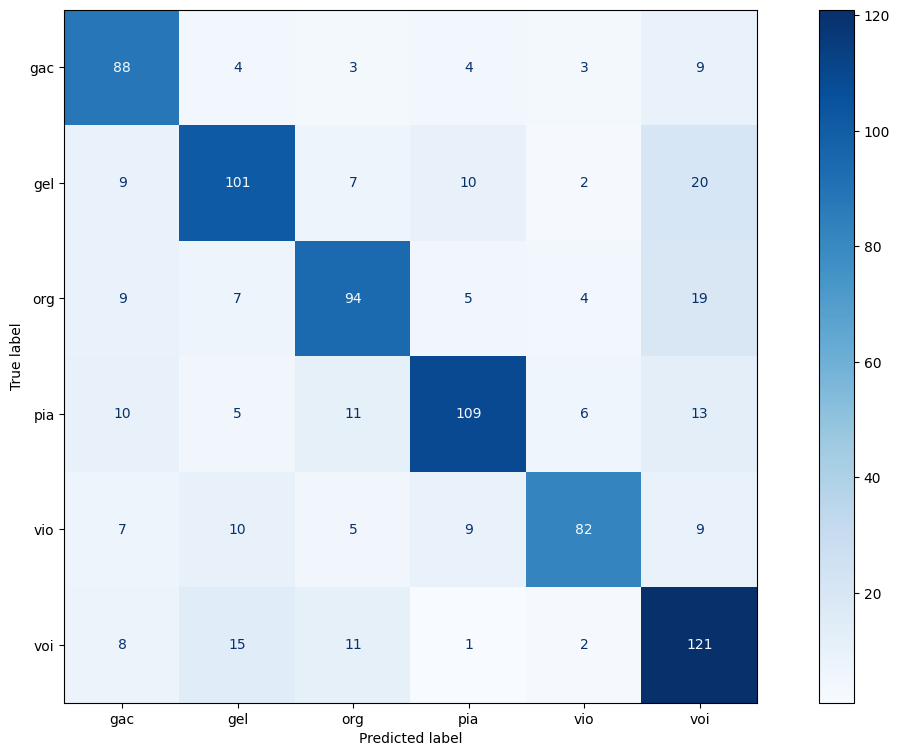

In [47]:
predicted_labels = gs.best_estimator_.predict(X_test)

best_rf_model = grid_search.best_estimator_
predicted_labels_rf = predicted_labels
gs_rf = gs

# save model
pickle.dump(best_rf_model, open('./rf.pkl', 'wb'))

print_model_result(predicted_labels)

### Training and evaluation with PCA


All models get trained again with PCA to see if a good performance can be achieved with reduced features.


In [81]:
# Initialze the estimators
clf1 = SVC()
clf2 = KNeighborsClassifier()
clf3 = LogisticRegression()
clf4 = KerasClassifier(build_fn=create_model, verbose=0, epochs=100, batch_size=10)
clf5 = RandomForestClassifier()

In [82]:
# hyperparameters for each dictionary
param1 = {}
param1['classifier__C'] = tuning_params_svm.get('C')
param1['classifier__gamma'] = tuning_params_svm.get('gamma')
param1['classifier__kernel'] = tuning_params_svm.get('kernel')
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__n_neighbors'] = knn_hyperparameters
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = tuning_params_logr.get('C')
param3['classifier__penalty'] = tuning_params_logr.get('penalty')
param3['classifier'] = [clf3]

param4 = {}
param4['classifier__neurons'] = param_grid_nn.get('neurons')
param4['classifier'] = [clf4]

param5 = {}
param5['classifier__max_depth'] = tuning_params_rf.get('max_depth')
param5['classifier__max_features'] = tuning_params_rf.get('max_features')
param5['classifier__min_samples_leaf'] = tuning_params_rf.get(
    'min_samples_leaf')
param5['classifier__min_samples_split'] = tuning_params_rf.get(
    'min_samples_split')
param5['classifier__n_estimators'] = tuning_params_rf.get('n_estimators')
param5['classifier'] = [clf5]

In [84]:
pipe = Pipeline([
    ('normalization', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('classifier', clf1)
])
params = [param1, param2, param3, param4, param5]

In [85]:
# pca grid search
gs_pca = GridSearchCV(pipe, params, cv=10, n_jobs=-1,
                      scoring='balanced_accuracy').fit(X_train, y_train)

In [86]:
print('Best classifier and parameters: '+str(gs_pca.best_params_))
print('Best balanced accuracy score: '+str(gs_pca.best_score_))
print('Best estimator explained variance: ' +
      str(gs_pca.best_estimator_.steps[1][1].explained_variance_))

Best classifier and parameters: {'classifier': SVC(C=9, gamma=0.1111111111111111), 'classifier__C': 9, 'classifier__gamma': 0.1111111111111111, 'classifier__kernel': 'rbf'}
Best balanced accuracy score: 0.7436118790442365
Best estimator explained variance: [8.46892436 2.61924635 2.16250091 1.65005612 1.37135232 1.35914306
 1.188743   1.06202433 0.80938195 0.73194684 0.61255276 0.58921957
 0.47799514 0.42911871 0.39737598 0.37914632 0.36545344 0.3222808 ]


Recall:  [0.82882883 0.7852349  0.72463768 0.67532468 0.72131148 0.70886076]
Recall Average:  0.7367788461538461
Precision:  [0.67647059 0.70481928 0.78740157 0.8        0.74576271 0.72258065]
Precision Average:  0.7367788461538461
F1-Score:  [0.74493927 0.74285714 0.75471698 0.73239437 0.73333333 0.71565495]
Accuracy: 0.74  , 613
Balanced accuracy: 0.74  , 0.7406997199242151
Number of samples: 832


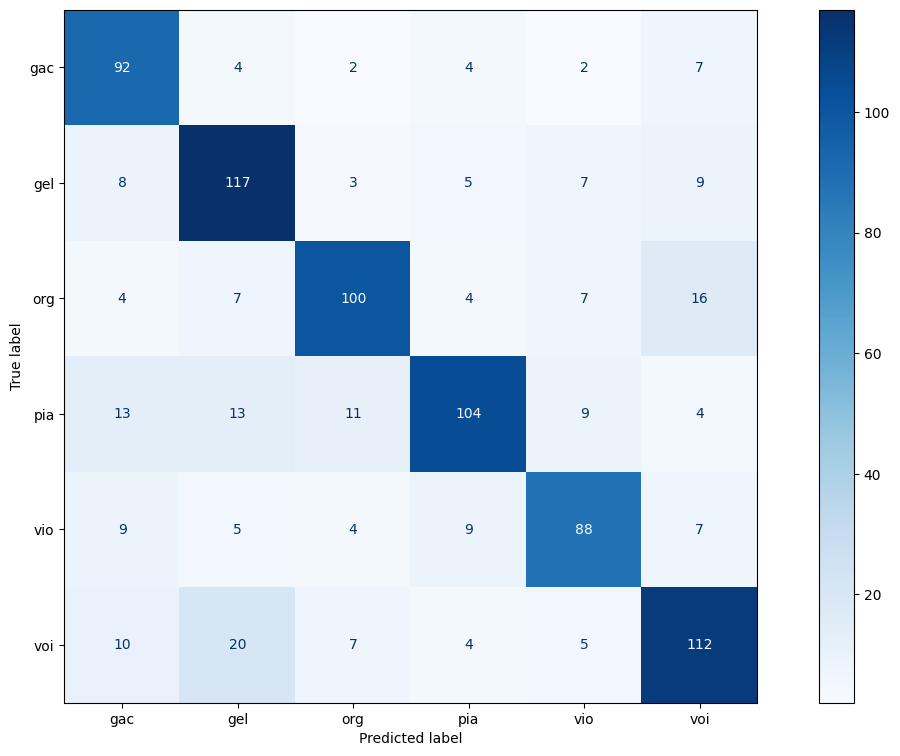

In [87]:
predicted_labels_pca = gs_pca.best_estimator_.predict(X_test)

best_pca_model = gs_pca.best_estimator_

print_model_result(predicted_labels_pca)

## Conclusion


### Model comparison


In [77]:
model_names = [
    'SVM',
    'Neural Network', 
    'KNN',
    'Logistic Regression', 
    'Random Forest', 
    'PCA SVM'
]

#### Best score after training

In [88]:
model_gs = [
    gs_svm, 
    gs_nn, 
    gs_knn, 
    gs_logreg, 
    gs_rf, 
    gs_pca
]

for i, model in enumerate(model_gs):
    print(model_names[i]+": Best balanced accuracy: "+str(model.best_score_))

SVM: Best balanced accuracy: 0.7751992643564594
Neural Network: Best balanced accuracy: 0.6725801626841227
KNN: Best balanced accuracy: 0.7581826718252549
Logistic Regression: Best balanced accuracy: 0.5514939437018225
Random Forest: Best balanced accuracy: 0.690840512331752
PCA SVM: Best balanced accuracy: 0.7436118790442365


#### Model evaluation with best hyperparameters

In [89]:
best_model_predictions = [
    predicted_labels_svm,  
    predicted_labels_knn,
    predicted_labels_nn,
    predicted_labels_logreg,
    predicted_labels_rf,
    predicted_labels_pca
]

for i, pred in enumerate(best_model_predictions):
    print(model_names[i])
    print(classification_report(y_test, pred))

SVM
              precision    recall  f1-score   support

           0       0.72      0.89      0.80       111
           1       0.74      0.80      0.77       149
           2       0.80      0.77      0.79       138
           3       0.82      0.71      0.76       154
           4       0.76      0.75      0.76       122
           5       0.79      0.75      0.77       158

    accuracy                           0.77       832
   macro avg       0.77      0.78      0.77       832
weighted avg       0.78      0.77      0.77       832

Neural Network
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       111
           1       0.71      0.79      0.75       149
           2       0.80      0.78      0.79       138
           3       0.82      0.77      0.80       154
           4       0.79      0.71      0.75       122
           5       0.79      0.78      0.79       158

    accuracy                           0.78       832
   m

SVM
              precision    recall  f1-score   support

           0       0.72      0.89      0.80       111
           1       0.74      0.80      0.77       149
           2       0.80      0.77      0.79       138
           3       0.82      0.71      0.76       154
           4       0.76      0.75      0.76       122
           5       0.79      0.75      0.77       158

    accuracy                           0.77       832
   macro avg       0.77      0.78      0.77       832
weighted avg       0.78      0.77      0.77       832

Neural Network
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       111
           1       0.71      0.79      0.75       149
           2       0.80      0.78      0.79       138
           3       0.82      0.77      0.80       154
           4       0.79      0.71      0.75       122
           5       0.79      0.78      0.79       158

    accuracy                           0.78       832
   macro avg       0.78      0.78      0.78       832
weighted avg       0.78      0.78      0.78       832

KNN
              precision    recall  f1-score   support

           0       0.62      0.79      0.69       111
           1       0.74      0.66      0.70       149
           2       0.71      0.75      0.73       138
           3       0.75      0.70      0.72       154
           4       0.72      0.68      0.70       122
           5       0.73      0.69      0.71       158

    accuracy                           0.71       832
   macro avg       0.71      0.71      0.71       832
weighted avg       0.71      0.71      0.71       832

Logistic Regression
              precision    recall  f1-score   support

           0       0.53      0.62      0.57       111
           1       0.48      0.49      0.49       149
           2       0.53      0.57      0.55       138
           3       0.68      0.70      0.69       154
           4       0.77      0.52      0.62       122
           5       0.50      0.51      0.51       158

    accuracy                           0.57       832
   macro avg       0.58      0.57      0.57       832
weighted avg       0.58      0.57      0.57       832

Random Forest
              precision    recall  f1-score   support

           0       0.67      0.79      0.73       111
           1       0.71      0.68      0.69       149
           2       0.72      0.68      0.70       138
           3       0.79      0.71      0.75       154
           4       0.83      0.67      0.74       122
           5       0.63      0.77      0.69       158

    accuracy                           0.72       832
   macro avg       0.73      0.72      0.72       832
weighted avg       0.72      0.72      0.72       832

PCA SVM
              precision    recall  f1-score   support

           0       0.68      0.83      0.74       111
           1       0.70      0.79      0.74       149
           2       0.79      0.72      0.75       138
           3       0.80      0.68      0.73       154
           4       0.75      0.72      0.73       122
           5       0.72      0.71      0.72       158

    accuracy                           0.74       832
   macro avg       0.74      0.74      0.74       832
weighted avg       0.74      0.74      0.74       832

### Final decision


The overall best model is the SVM without PCA. Even though, KNN is the simpler model it only uses one neighbor therefore the overfitting is very likely. Our goal for the project was to get an accuracy of around 75% and this was achieved with this model.

#### Most predictable instruments


The most predictable instruments based on recall and precision with the selected model are the acoustic guitar and the organ. The most problems had the model predicting the violin.

In [90]:
print('Recall')
rec_score = recall_score(y_test, predicted_labels_svm, average=None)
for idx, inst in enumerate(Instruments):
    print(inst+': '+str(rec_score[idx]))
print()
print('Precision')
rec_score = precision_score(y_test, predicted_labels_svm, average=None)
for idx, inst in enumerate(Instruments):
    print(inst+': '+str(rec_score[idx]))

Recall
gac: 0.8918918918918919
gel: 0.7986577181208053
org: 0.7681159420289855
pia: 0.7077922077922078
vio: 0.7459016393442623
voi: 0.7468354430379747

Precision
gac: 0.717391304347826
gel: 0.7391304347826086
org: 0.803030303030303
pia: 0.8195488721804511
vio: 0.7647058823529411
voi: 0.7919463087248322


## Demo


This demo shows how the best model performs on some of the 3 second excerpts as well as one of the longer 5 - 20 seconds audio samples.


In [58]:
def predict_instrument(filename):

    # load model
    # svm_model = pickle.load(open('./model.pkl', 'rb'))

    # load scaler
    # scaler = pickle.load(open('./scaler.pkl','rb'))

    y, sr = librosa.load(filename, sr=44100)
    rms = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    melspec = librosa.feature.melspectrogram(y=y, sr=sr)

    columns = ['rms', 'spectral_centroid', 'spectral_bandwidth',
               'rolloff', 'zero_crossing_rate', 'melspectrogram']
    for i in range(len(mfcc)):
        columns.append('mfcc' + str(i+1))

    rows = [np.mean(rms), np.mean(spec_cent), np.mean(spec_bw),
            np.mean(rolloff), np.mean(zcr), np.mean(melspec)]

    for i in mfcc:
        rows.append(np.mean(i))

    # create dataframe
    df_test = pd.DataFrame([rows])
    df_test.columns = columns

    # uniformly scale data
    test_transform = scaler.transform(df_test.values)

    return best_svm_model.predict(test_transform)

In [59]:
file_name = './IRMAS-TrainingData/voi/033__[voi][nod][pop_roc]2467__1.wav'
result = predict_instrument(file_name)

Instruments[result[0]]

'voi'

In [60]:
file_name = './IRMAS-TrainingData/vio/099__[vio][nod][cla]2172__1.wav'
result = predict_instrument(file_name)

Instruments[result[0]]

'vio'

In [61]:
file_name = './IRMAS-TrainingData/gac/040__[gac][nod][cou_fol]0713__2.wav'
result = predict_instrument(file_name)

Instruments[result[0]]

'gac'

In [62]:
file_name = './IRMAS-TrainingData/gel/251__[gel][dru][pop_roc]0833__2.wav'
result = predict_instrument(file_name)

Instruments[result[0]]

'gel'

In [64]:
file_name = './IRMAS-TestingData-Part1/Part1/00 - gold fronts-12.wav'
result = predict_instrument(file_name)

Instruments[result[0]]

'voi'